In [1]:
# Basic Libraries
import sys
import time
import gc
import random
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Data Handling and Image Processing
from torchvision import datasets, transforms

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import structural_similarity as ssim

# Style for Matplotlib
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Scientific Computing and Machine Learning
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import subspace_angles
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Custom Modules and Extensions
sys.path.append("../netrep/")
sys.path.append("../svcca/")
import cca_core
from netrep.metrics import LinearMetric
import networks as nets  # Contains RNNs
import net_helpers
import tasks
import helper
import mpn

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Memory Optimization
gc.collect()
torch.cuda.empty_cache()

In [2]:
# 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',]
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',]
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',]
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
hyp_dict = {}

In [3]:
# Reload modules if changes have been made to them
from importlib import reload

reload(nets)
reload(net_helpers)

fixseed = False # randomize setting the seed may lead to not perfectly solved results
seed = random.randint(1,1000) if not fixseed else 8 # random set the seed to test robustness by default
print(f"Set seed {seed}")
np.random.seed(seed)
torch.manual_seed(seed)

hyp_dict['task_type'] = 'multitask' # int, NeuroGym, multitask
hyp_dict['mode_for_all'] = "random_batch"
hyp_dict['ruleset'] = 'delaygofamily' # low_dim, all, test

accept_rules = ('fdgo', 'fdanti', 'delaygo', 'delayanti', 'reactgo', 'reactanti', 
                'delaydm1', 'delaydm2', 'dmsgo', 'dmcgo', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm')


rules_dict = \
    {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'low_dim' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
                 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
                 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],

     'gofamily': ['fdgo', 'fdanti', 'reactgo', 'reactanti', 'delaygo', 'delayanti'],

     'delaygo': ['delaygo'],
     'delaygofamily': ['delaygo', 'delayanti'],
     'fdgo': ['fdgo'],
     'fdfamily': ['fdgo', 'fdanti'],
     'reactgo': ['reactgo'],
     'reactfamily': ['reactgo', 'reactanti'],
     
     'delaydm1': ['delaydm1'],
     'delaydmfamily': ['delaydm1', 'delaydm2'],
     
     'dmsgofamily': ['dmsgo', 'dmsnogo'],
     'dmsgo': ['dmsgo'],
     'dmcgo': ['dmcgo'],
     'contextdelayfamily': ['contextdelaydm1', 'contextdelaydm2'],
    }
    

# This can either be used to set parameters OR set parameters and train
train = True # whether or not to train the network
verbose = True
hyp_dict['run_mode'] = 'minimal' # minimal, debug
hyp_dict['chosen_network'] = "vanilla"

# suffix for saving images
hyp_dict['addon_name'] = ""

mpn_depth = 1
n_hidden = 100

# for coding 
if hyp_dict['chosen_network'] in ("gru", "vanilla"):
    mpn_depth = 1

def current_basic_params():
    task_params = {
        'task_type': hyp_dict['task_type'],
        'rules': rules_dict[hyp_dict['ruleset']],
        'dt': 40, # ms, directly influence sequence lengths,
        'ruleset': hyp_dict['ruleset'],
        'n_eachring': 8, # Number of distinct possible inputs on each ring
        'in_out_mode': 'low_dim',  # high_dim or low_dim or low_dim_pos (Robert vs. Laura's paper, resp)
        'sigma_x': 0.00, # Laura raised to 0.1 to prevent overfitting (Robert uses 0.01)
        'mask_type': 'cost', # 'cost', None
        'fixate_off': False, # Second fixation signal goes on when first is off
        'task_info': True, 
        'randomize_inputs': True,
        'n_input': 20, # Only used if inputs are randomized,
        'modality_diff': False
    }

    print(f"Fixation_off: {task_params['fixate_off']}; Task_info: {task_params['task_info']}")

    train_params = {
        'lr': 1e-4,
        'n_batches': 64,
        'batch_size': 64,
        'gradient_clip': 10,
        'valid_n_batch': 200,
        'n_datasets': 100, # Number of distinct batches
        'n_epochs_per_set': 200, # longer/shorter training
        'task_mask': None, # None, task
        # 'weight_reg': 'L2',
        # 'reg_lambda': 1e-4,
    }

    if not train: # some 
        assert train_params['n_epochs_per_set'] == 0    

    net_params = {
        'net_type': hyp_dict['chosen_network'], # mpn1, dmpn, vanilla
        'n_neurons': [1] + [n_hidden] * mpn_depth + [1],
        'output_bias': False, # Turn off biases for easier interpretation
        'loss_type': 'MSE', # XE, MSE
        'activation': 'tanh', # linear, ReLU, sigmoid, tanh, tanh_re, tukey, heaviside
        'cuda': True,
        'monitor_freq': 100,
        'monitor_valid_out': True, # Whether or not to save validation output throughout training
        'output_matrix': '',# "" (default); "untrained", or "orthogonal"
        'input_layer_add': False, 
        'input_layer_bias': False,
        
        'input_layer': 'frozen',
        
        # for one-layer MPN, GRU or Vanilla
        'ml_params': {
            'bias': True, # Bias of layer
            'mp_type': 'mult',
            'm_update_type': 'hebb_assoc', # hebb_assoc, hebb_pre
            'eta_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'eta_train': False,
            # 'eta_init': 'mirror_gaussian', #0.0,
            'lam_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'm_time_scale': 400, # ms, sets lambda
            'lam_train': False,
            'W_freeze': False,
        },

        # Vanilla RNN params
        'leaky': True,
        'alpha': 0.2,
    }

    # for multiple MPN layers, assert 
    if mpn_depth > 1:
        for mpl_idx in range(mpn_depth - 1):
            assert f'ml_params{mpl_idx}' in net_params.keys()

    # actually I don't think it is needed
    # putting here to warn the parameter checking every time 
    # when switching network
    if hyp_dict['chosen_network'] in ("gru", "vanilla"):
        assert f'ml_params' in net_params.keys()

    return task_params, train_params, net_params

task_params, train_params, net_params = current_basic_params()

shift_index = 1 if not task_params['fixate_off'] else 0

if hyp_dict['task_type'] in ('multitask',):
    task_params, train_params, net_params = tasks.convert_and_init_multitask_params(
        (task_params, train_params, net_params)
    )

    net_params['prefs'] = tasks.get_prefs(task_params['hp'])

    print('Rules: {}'.format(task_params['rules']))
    print('  Input size {}, Output size {}'.format(
        task_params['n_input'], task_params['n_output'],
    ))
else:
    raise NotImplementedError()

if net_params['cuda']:
    print('Using CUDA...')
    device = torch.device('cuda')
else:
    print('Using CPU...')
    device = torch.device('cpu')

# how many epoch each dataset will be trained on
epoch_multiply = train_params["n_epochs_per_set"]

Set seed 817
Fixation_off: False; Task_info: True
Rules: ['delaygo', 'delayanti']
  Input size 20, Output size 3
Using CUDA...


In [4]:
hyp_dict["mess_with_training"] = False

if hyp_dict['mess_with_training']:
    hyp_dict['addon_name'] += "messwithtraining"

params = task_params, train_params, net_params

if net_params['net_type'] == 'mpn1':
    netFunction = mpn.MultiPlasticNet
elif net_params['net_type'] == 'dmpn':
    netFunction = mpn.DeepMultiPlasticNet
elif net_params['net_type'] == 'vanilla':
    netFunction = nets.VanillaRNN
elif net_params['net_type'] == 'gru':
    netFunction = nets.GRU

In [5]:
test_n_batch = train_params["valid_n_batch"]
color_by = "stim" # or "resp" 

task_random_fix = True
if task_random_fix:
    print(f"Align {task_params['rules']} With Same Time")

if task_params['task_type'] in ('multitask',): # Test batch consists of all the rules
    task_params['hp']['batch_size_train'] = test_n_batch
    # using homogeneous cutting off
    test_mode_for_all = "random"
    # ZIHAN
    # generate test data using "random"
    test_data, test_trials_extra = tasks.generate_trials_wrap(task_params, test_n_batch, \
                rules=task_params['rules'], mode_input=test_mode_for_all, fix=task_random_fix)
    _, test_trials, test_rule_idxs = test_trials_extra

    print(test_trials)

    task_params['dataset_name'] = 'multitask'

    if task_params['in_out_mode'] in ('low_dim_pos',):
        output_dim_labels = ('Fixate', 'Cos', '-Cos', 'Sin', '-Sin')
    elif task_params['in_out_mode'] in ('low_dim',):
        output_dim_labels = ('Fixate', 'Cos', 'Sin')
    else:
        raise NotImplementedError()

    labels_resp, labels_stim = [], []
    for rule_idx, rule in enumerate(task_params['rules']):
        print(rule)
        if rule in accept_rules:
            if hyp_dict['ruleset'] in ('dmsgo', 'dmcgo'):
                labels.append(test_trials[rule_idx].meta['matches'])
            else:
                labels_resp.append(test_trials[rule_idx].meta['resp1'])
                labels_stim.append(test_trials[rule_idx].meta['stim1']) 

        else:
            raise NotImplementedError()
            
    labels_resp = np.concatenate(labels_resp, axis=0).reshape(-1,1)
    labels_stim = np.concatenate(labels_stim, axis=0).reshape(-1,1)

if color_by == "stim":
    labels = labels_stim
else:
    labels = labels_resp
    
test_input, test_output, test_mask = test_data

permutation = np.random.permutation(test_input.shape[0])
test_input = test_input[permutation]
test_output = test_output[permutation]
test_mask = test_mask[permutation]
labels = labels[permutation]

test_input_np = test_input.detach().cpu().numpy()
test_output_np = test_output.detach().cpu().numpy()

n_batch_all = test_input_np.shape[0] # Total number of batches, might be different than test_n_batch
max_seq_len = test_input_np.shape[1]

if task_params["randomize_inputs"]: 
    rmat = task_params["randomize_matrix"]
    test_input_np = np.matmul(test_input_np, np.linalg.pinv(rmat))

test_task = [] # which task
for batch_idx in range(test_input_np.shape[0]):
    
    task_label = test_input_np[batch_idx, 0, 6-shift_index:]
    task_label_index = np.where(np.isclose(task_label, 1, atol=0.1))[0][0]
    test_task.append(task_label_index)


Align ['delaygo', 'delayanti'] With Same Time
rng reset with seed 6819
rng reset with seed 6819
[<tasks.Trial object at 0x14cef98eba90>, <tasks.Trial object at 0x14cef98eba60>]
delaygo
delayanti


In [6]:
# we use net at different training stage on the same test_input
net, _, (counter_lst, netout_lst, db_lst, Winput_lst, Winputbias_lst, \
         Woutput_lst, Wall_lst, marker_lst, loss_lst, acc_lst) = net_helpers.train_network(params, device=device, verbose=verbose, train=train, hyp_dict=hyp_dict, netFunction=netFunction, test_input=test_input)
counter_lst = [x * epoch_multiply + 1 for x in counter_lst] # avoid log plot issue    

Vanilla RNN:
  n_neurons - input: 20, hidden: 100, output: 3
  input layer: frozen // rec layer: trainable // output layer: trainable
  Act: tanh
  Leaky updates, timescale 50 ms (old: 0.2 new: 0.8)
How about Test Data at dataset 0
Train parameters:
  Loss: MSE // LR: 1.00e-04 // Optim: adam
  Grad type: backprop // Gradient clip: 1.0e+01
Weight reg: None
Iter: 0, LR: 1.000e-04 - train_loss:4.039e-01, rounded train_acc:0.302, valid_loss:3.916e-01, rounded valid_acc:0.286
Iter: 100, LR: 1.000e-04 - train_loss:2.022e-01, rounded train_acc:0.330, valid_loss:2.584e-01, rounded valid_acc:0.540
Iter: 200, LR: 1.000e-04 - train_loss:1.216e-01, rounded train_acc:0.248, valid_loss:2.888e-01, rounded valid_acc:0.527
How about Test Data at dataset 1
Iter: 300, LR: 1.000e-04 - train_loss:2.017e-01, rounded train_acc:0.235, valid_loss:2.012e-01, rounded valid_acc:0.249
Iter: 400, LR: 1.000e-04 - train_loss:1.428e-01, rounded train_acc:0.237, valid_loss:2.154e-01, rounded valid_acc:0.243
How about T

In [7]:
if hyp_dict['chosen_network'] == "dmpn":
    if net_params["input_layer_add"]:
        input_matrix = net.W_initial_linear.weight.data.detach().cpu().numpy()
        figinp, axsinp = plt.subplots(1,1,figsize=(4,4))
        sns.heatmap(input_matrix, ax=axsinp, square=True, cmap='coolwarm')

In [8]:
# sanity check, if W_freeze, then the recorded W matrix for the modulation layer should not be changed
if net_params["ml_params"]["W_freeze"]: 
    assert np.allclose(Wall_lst[-1][0], Wall_lst[0][0])

if net_params["input_layer_bias"]: 
    assert net_params["input_layer_add"] is True 

Done!


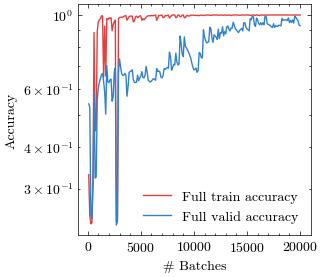

In [9]:
if train:
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    ax.plot(net.hist['iters_monitor'][1:], net.hist['train_acc'][1:], color=c_vals[0], label='Full train accuracy')
    ax.plot(net.hist['iters_monitor'][1:], net.hist['valid_acc'][1:], color=c_vals[1], label='Full valid accuracy')
    if net.weight_reg is not None:
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_output_label'], color=c_vals_l[0], zorder=-1, label='Output label')
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_reg_term'], color=c_vals_l[0], zorder=-1, label='Reg term', linestyle='dashed')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_output_label'], color=c_vals_l[1], zorder=-1, label='Output valid label')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_reg_term'], color=c_vals_l[1], zorder=-1, label='Reg valid term', linestyle='dashed')
    
    ax.set_yscale('log')
    ax.legend()
    # ax.set_ylabel('Loss ({})'.format(net.loss_type))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('# Batches')
    plt.savefig(f"./paper/loss_{hyp_dict['ruleset']}_{task_params['fixate_off']}.png", dpi=300)
    
print('Done!')

In [10]:
if train:
    net_helpers.net_eta_lambda_analysis(net, net_params, hyp_dict)

In [11]:
use_finalstage = False
if use_finalstage:
    # plotting output in the validation set
    net_out, db = net.iterate_sequence_batch(test_input, run_mode='track_states')
    W_output = net.W_output.detach().cpu().numpy()

    W_all_ = []
    for i in range(len(net.mp_layers)):
        W_all_.append(net.mp_layers[i].W.detach().cpu().numpy())
    W_ = W_all_[0]
    
else:
    ind = len(marker_lst)-1 
    # ind = 0
    network_at_percent = (marker_lst[ind]+1)/train_params['n_datasets']*100
    print(f"Using network at {network_at_percent}%")
    net_out = netout_lst[ind]
    db = db_lst[ind]
    W_output = Woutput_lst[ind]
    # W_ = Wall_lst[ind][0]
    

Using network at 100.0%


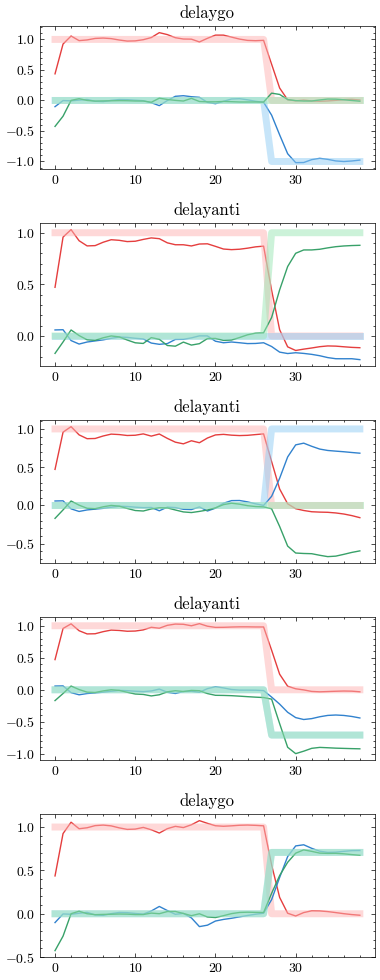

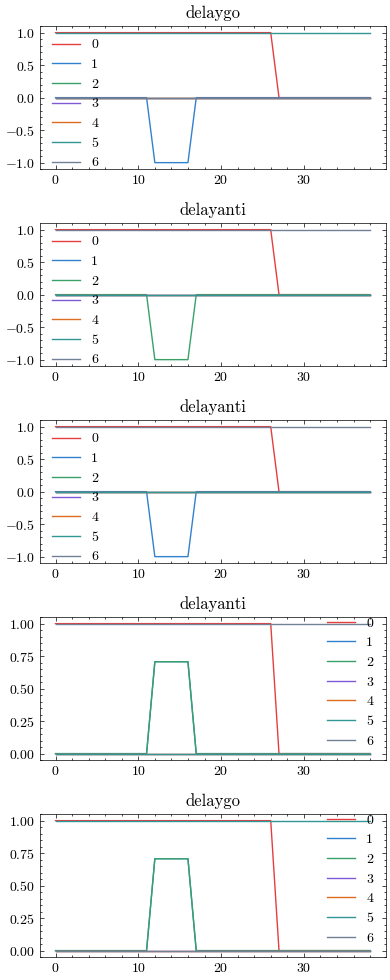

In [12]:
if net_params['loss_type'] in ('MSE',):
    fig, axs = plt.subplots(5, 1, figsize=(4, 5*2))
    figin, axsin = plt.subplots(5, 1, figsize=(4, 5*2))

    if test_output_np.shape[-1] == 1:
        for batch_idx, ax in enumerate(axs):
            ax.plot(net_out[batch_idx, :, 0], color=c_vals[batch_idx])
            ax.plot(test_output_np[batch_idx, :, 0], color=c_vals_l[batch_idx])

    else:
        for batch_idx, ax in enumerate(axs):
            for out_idx in range(test_output_np.shape[-1]):
                axs[batch_idx].plot(net_out[batch_idx, :, out_idx], color=c_vals[out_idx])
                axs[batch_idx].plot(test_output_np[batch_idx, :, out_idx], color=c_vals_l[out_idx], linewidth=5, alpha=0.5)
                axs[batch_idx].set_title(f"{task_params['rules'][test_task[batch_idx]]}")

            input_batch = test_input[batch_idx,:,:].cpu().numpy()
            if task_params["randomize_inputs"]: 
                input_batch = np.matmul(input_batch, np.linalg.pinv(rmat))
            for inp_idx in range(input_batch.shape[-1]):
                axsin[batch_idx].plot(input_batch[:,inp_idx], color=c_vals[inp_idx], label=inp_idx)
                axsin[batch_idx].set_title(f"{task_params['rules'][test_task[batch_idx]]}")
                axsin[batch_idx].legend()

    # fig.suptitle(f"Validation Set Output Comparison using Network at Percentage {network_at_percent}%")
    fig.tight_layout()
    fig.savefig(f"./paper/lowD_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}.png", dpi=300)


    # figin.suptitle(f"Validation Set Output Comparison using Network at Percentage {network_at_percent}%")
    figin.tight_layout()
    figin.savefig(f"./paper/lowD_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}_input.png", dpi=300)

In [13]:
# here db is selected based on learning stage selection 

layer_index = 0 # 1 layer MPN 
if net_params["input_layer_add"]:
    layer_index += 1 
    
def modulation_extraction(db, layer_index):
    """
    """
    Ms = np.concatenate((
        db[f'M{layer_index}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1),
    ), axis=-1)

    Ms_orig = np.concatenate((
        db[f'M{layer_index}'].detach().cpu().numpy(),
    ), axis=-1)

    bs = np.concatenate((
        db[f'b{layer_index}'].detach().cpu().numpy(),
    ), axis=-1) 

    hs = np.concatenate((
        db[f'hidden{layer_index}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1),
    ), axis=-1)

    return Ms, Ms_orig, hs, bs
    
if net_params["net_type"] in ("dmpn", ):
    if mpn_depth == 1:
        Ms, Ms_orig, hs, bs = modulation_extraction(db, layer_index)
    else:
        modulations, hiddens = [], []
        for i in range(mpn_depth):
            modulations.append(db[f'M{i}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1))
            hiddens.append(db[f'hidden{i}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1),)

        Ms = modulations[0]
        hs = hiddens[0]
        
elif net_params["net_type"] in ("vanilla", "gru"):
    hs = db['hidden'].detach().cpu().numpy()

pca_type = 'full' # full, cell_types
pca_target_lst = ['hs', 'Ms'] # hs, 'Ms' 
if net_params["net_type"] in ("vanilla", "gru"):
    pca_target_lst = ['hs'] # if not dmpn, no M information effectively

In [14]:
# using recorded information
recordkyle_all, recordkyle_nameall = [], []
for test_subtrial in test_trials:
    metaepoch = test_subtrial.epochs
    periodname = list(metaepoch.keys())
    recordkyle, recordkyle_name = [], []
    for keyiter in range(len(periodname)):
        try:
            recordkyle_name.append(periodname[keyiter])
            if test_mode_for_all == "random":
                recordkyle.append(metaepoch[periodname[keyiter]][1])
            elif test_mode_for_all == "random_batch":
                recordkyle.append(list(metaepoch[periodname[keyiter]][1]))
        except Exception as e:
            print(e)
    
    if test_mode_for_all in ("random",):
        fillrecordkyle = []
        for timestamp in recordkyle:
            fillrecordkyle.append([timestamp for _ in range(hs.shape[0])])
        recordkyle = fillrecordkyle

    recordkyle.insert(0, [0 for _ in range(len(recordkyle[1]))])
    recordkyle = np.array(recordkyle).T.tolist()
    recordkyle_all.extend(recordkyle)
    recordkyle_nameall.append(recordkyle_name)

In [15]:
# Sep 30th
# This part of code should be adaptive for multitask, which may have different breaks and periods for each task
unique_lists = set(tuple(lst) for lst in recordkyle_all)
# here select task specific information
# which maximally should have length of number of tasks
unique_recordkyle_all = [list(lst) for lst in unique_lists]
if not task_random_fix:
    assert len(unique_recordkyle_all) >= len(rules_dict[hyp_dict['ruleset']])
else:
    print("Test DataSet Random Seed Is Fixed")

all_session_breakdown = []
for task_specific_time in unique_recordkyle_all:
    session_breakdown = []
    for sindex in range(0,len(task_specific_time)-1):
        # all sessions should be the same for each task
        # but different across tasks
        # though the time of when response period starts might be similar across
        session_breakdown.append([task_specific_time[sindex], task_specific_time[sindex+1]]) 
    session_breakdown.append([task_specific_time[0], task_specific_time[-1]])
    all_session_breakdown.append(session_breakdown)

# break down time
all_breaks = []
for session_breakdown in all_session_breakdown:
    breaks = [cut[1] for cut in session_breakdown[:-1]]
    print(f"Task {all_session_breakdown.index(session_breakdown)}; breaks: {breaks}")
    all_breaks.append(breaks)

# for delay-task
assert len(all_breaks)
response_start = all_breaks[0][-2]
stimulus_start = all_breaks[0][0]
stimulus_end = all_breaks[0][1]
print(f"response_start: {response_start}")
print(f"stimulus_start: {stimulus_start}")
print(f"stimulus_end: {stimulus_end}")

Test DataSet Random Seed Is Fixed
Task 0; breaks: [12, 17, 27, 39]
response_start: 27
stimulus_start: 12
stimulus_end: 17


In [16]:
label_task_comb = []
for i in range(len(labels)):
    label_task_comb.append([labels[i][0], test_task[i]])
label_task_comb_arr = np.array(label_task_comb)

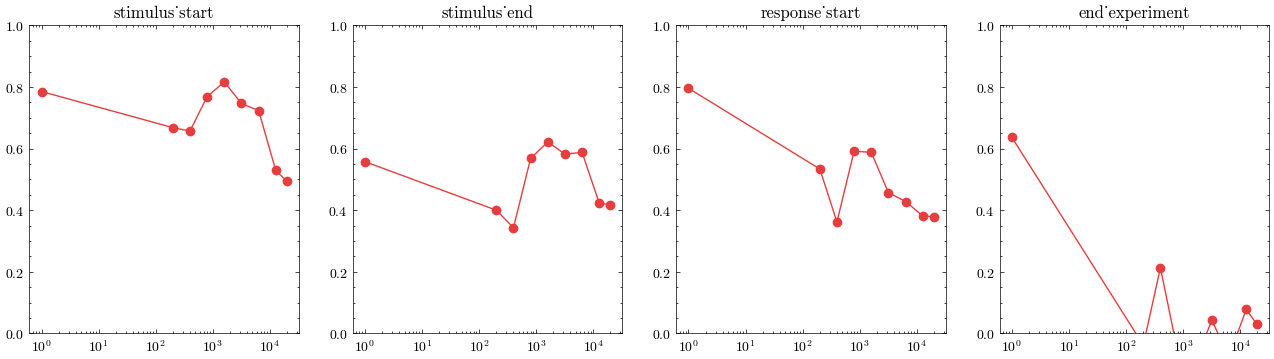

In [17]:
cos_values_stage = [] 
time_index_lst = [stimulus_start, stimulus_end, response_start, breaks[-1]-1] # breaks[-1]: end of experiment
time_index_name = ["stimulus_start", "stimulus_end", "response_start", "end_experiment"]

for i in range(len(db_lst)):
    hidden_state = db_lst[i]["hidden"].detach().cpu().numpy()
    cos_values = [] 
    for stimulus_index in range(8): 
        ind1 = [i for i, lst in enumerate(label_task_comb) if lst == [stimulus_index, 0]]
        ind2 = [i for i, lst in enumerate(label_task_comb) if lst == [(stimulus_index + 4) % 8, 1]]

        temp = [] 
        for t in time_index_lst:
            h1 = hidden_state[ind1[0],t,:]
            h2 = hidden_state[ind2[0],t,:]
            cos_value = 1 - cosine(h1, h2)
            temp.append(cos_value)
        cos_values.append(temp)

    cos_values_stage.append(np.mean(np.array(cos_values), axis=0))

cos_values_stage = np.array(cos_values_stage)

fig, axs = plt.subplots(1,len(time_index_lst),figsize=(4*len(time_index_lst),4))
for i in range(len(time_index_lst)):
    axs[i].plot(counter_lst, cos_values_stage[:,i], "-o", c=c_vals[0], label="Loss")
    axs[i].set_title(time_index_name[i])
for ax in axs:
    ax.set_xscale("log")
    ax.set_ylim([0,1])
fig.savefig("./paper/hidden_compare.png")

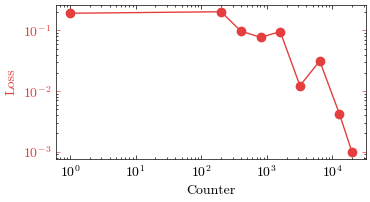

In [18]:
fig, ax1 = plt.subplots(figsize=(4,2))  # Create a new figure

ax1.plot(counter_lst, loss_lst, "-o", c=c_vals[0], label="Loss")
ax1.set_ylabel("Loss", color=c_vals[0])
ax1.tick_params(axis='y', colors=c_vals[0])
ax1.set_yscale("log")  # Keep log scale for loss
ax1.set_xlabel("Counter")
ax1.set_xscale("log")